# pyzzle
---
## はじめに
スケルトンパズルの自動生成ライブラリ`pyzzle`を紹介します。  
ここでは簡単な使い方の説明にとどめ， ライブラリの拡張等については別途解説を用意します。

## インストール方法
本ライブラリをインストールする方法はいくつかあります。
1. PyPIを用いたインストール

    ```
    pip install pyzzle
    ```

2. Anacondaを用いたインストール（未対応）

    ```
    conda install pyzzle
    ```

3. GitHubを用いたインストール

    ```
    git clone https://github.com/puzzle-japan/pyzzle.git
    cd pyzzle
    python setup.py install
    ```

## 辞書の用意
パズルに配置する単語のリストを`txt`形式で生成します。  

```animal.txt
アイアイ
アイベックス
アカカンガルー
アカギツネ
アカクビワラビー
```

なお， 単語に重み（点数）をつける場合は， 以下のように生成します。  

```animal_ww.txt
アイアイ 10
アイベックス 2
アカカンガルー 50
アカギツネ 20
アカクビワラビー 70
```
重みを設定することにより， より重みのある単語が優先的にパズルに配置されるようになります。

## パズル生成
### 必要ライブラリのインポート

In [1]:
import sys

import numpy as np

sys.path.append("../") # ライブラリインストール後は削除
from pyzzle import Puzzle, FancyPuzzle, Dictionary, ObjectiveFunction, Optimizer

### 変数設定
* dict_path : 辞書オブジェクトのパス
* width : パズルの横幅
* height : パズルの縦幅
* seed : 乱数のシード値

In [2]:
dict_path = "../dict/pokemon.txt"  # countries hokkaido animals kotowaza birds dinosaurs fishes sports
width = 15
height = 15
seed = 1

# 乱数設定
np.random.seed(seed=seed)

### Puzzleインスタンスの生成
`Puzzle`クラスは， 生成するパズルのメインオブジェクトです。  
初期化時には横幅と縦幅を指定します。  
任意の形状の盤面を作成する場合は， 後に紹介する`FancyPuzzle`クラスを用います。

In [3]:
puzzle = Puzzle(width, height)

### Dictionary, ObjectiveFunction, Optimizerインスタンスの生成
* パズルに配置する単語リストとして， `Dictionary`クラスを使用します。このクラスは事前に用意した辞書ファイルに基づき， 重複単語や不要単語の消去， 自動的に重みを算出するなど， 単語リスト全般の処理に携わります。  
* パズルの良し悪しを決定するために， `ObjectiveFunction`（目的関数）クラスを使用します。このクラスについては後ほど改めて紹介します。  
* `pyzzle`におけるパズル生成は， ランダムに作成された初期状態のパズルを出発点とし， 新たにランダム生成されるパズルとパズルの良し悪しを比較し， より良いパズルを選択するというプロセスを繰り返して美しいパズルを作り上げていきます。その際に必要になるのが， `Optimizer`（最適化関数）クラスです。このクラスについては後ほど改めて紹介します。

In [4]:
dic = Dictionary(dict_path)
obj_func = ObjectiveFunction()
optimizer = Optimizer()

### Puzzleインスタンスに辞書をインポートする
`Puzzle`インスタンスはパズル生成に`Dictionary`インスタンスを用います。  
そのために， `Puzzle`インスタンスに`Dictionary`インスタンスを`import_dict`メソッドによりインポートする必要があります。  
これにより， パズル生成に使う単語群を知ることができます。

In [5]:
puzzle.import_dict(dic)

### ObjectiveFunctionインスタンスに使用する目的関数を登録する
ここでは， `ObjectiveFunction`クラスについて解説します。  
`ObjectiveFunction`クラスは， パズルの良し悪しを定量化するための目的関数を取り扱うクラスです。  
「良いパズル」とはどういうパズルでしょう？ その答えは， おそらく無数にあることでしょう。  
ここでは`pyzzle`が提供する複数の指標を紹介します。  

|目的関数名|意味|
|-|-|
|`weight`|重みの合計|
|`nwords`|パズルに使われた語数|
|`cross_count`|単語同士の交差マス数|
|`fill_count`|パズル全体の文字マス数|
|`max_connected_empties`|空マスの最大連結数|
|`difficulty`|パズルの難易度|
|`ease`|パズルの容易度|

なお， `difficulty`と`ease`は反対の関係で， 目的に応じて使い分けます。  
`pyzzle`ではこれらの目的関数に加え， 自ら定義した目的関数の拡張にも対応しています。  
具体的な実装方法については， 別のドキュメントを参照してください。  

これらの目的関数を`ObjectiveFunction`インスタンスに登録するには， `register`メソッドを用います。  
`register`メソッドの引数には， 使用する目的関数名のリストを渡します。

`pyzzle`ではパズルの改善時に使用する目的関数に優先順位を付けることができます。  
`ObjectiveFunction`インスタンスに目的関数を登録する際, 上位にある目的関数ほど優先的に比較が行われます。  
例えば， 下の実装では`weight`が最優先され， 次に`nwords`が優先されます。  

In [6]:
obj_func.register(
    ["weight",
    "nwords", 
    "cross_count", 
    "fill_count", 
    "max_connected_empties", 
    "difficulty"]
    )

### Optimizerクラスに最適化手法をセットする
`pyzzle`では， ランダムに初期化されたパズルを出発点とし， そのパズルを改善していくことで美しいパズルを生成します。  
では， パズルの「改善」はどのように行うのでしょうか？ このような問題を「組み合わせ最適化問題」と呼びます。  
`pyzzle`では， いくつかの最適化手法を提供します。  

|指定子|最適化手法名|
|-|-|
|`local_search`|局所探索法|
|`iterated_local_search`|反復局所探索法|

ここでは最も基本的な手法として， 数ある最適化手法の中から「局所探索法」を紹介します。
これは、組み合わせ最適化問題を解く近似解法として代表的なものです。
局所探索法について簡単に解説します。  
まず， ランダムに初期化されたパズルを「初期解」とします。次に， 解空間（全てのパズルの解を含む多次元空間）の中で， 初期解の近傍領域に存在する「近傍解」を探します。 
近傍解とは、初期解に似ている（解空間において距離の近い）解を意味します。よって、近傍解は初期解を元に得ることができます。  
ある手順を踏むことで近傍解が得られたら， 初期解の目的関数値と近傍解の目的関数値を比較します。目的関数値はパズルの良し悪しの指標ですので， 目的関数値から良いパズルと判断された方を新たな解とします（近傍解が必ずしも初期解よりも良いとは限りません）。  
このプロセスを繰り返すことで， 初期解の改善を行う手法を「局所探索法」と呼びます。初期解が既に十分良い解だった場合， あまり改善せずとも良いパズルが得られたりします。改悪することはありません。

`pyzzle`における「近傍解」の定義は最適化手法にもよりますが， `local_search`においては次の手順で近傍解を取得しています：

    1. 既存のパズルに配置された単語をランダムに取り除く(drop)
    2. 単語の連結性が崩れるまで繰り返し， 1つだった単語の島が2つ以上の島に分離したら単語のdropをストップする(collapse)
    3. 最も面積の大きい島だけを残して， それ以外の島を盤面から取り除く(kick)
    4. 大きい島だけを残した状態から， 再びパズルを完成させる

これが`local_search`における近傍解の取得プロセスです。  
最適化手法の拡張には， このライブラリを十分に理解している必要があります。これについては， 別ドキュメントを参照してください。

In [7]:
optimizer.set_method("local_search")

### 目的関数と最適化手法をPuzzleインスタンスにコンパイルする
これまでに用意した`ObjectiveFunction`インスタンスと`Optimizer`インスタンスを`Puzzle`インスタンスで使用可能にするために， `compile`メソッドを呼びます。  
これにより， 解の改善が可能になります。

In [8]:
puzzle.compile(obj_func=obj_func, optimizer=optimizer)

### 初期解の生成
まずは， 初期解を生成します。  
初期解の生成には`first_solve`メソッドを使用します。  

初期解の生成は次のアルゴリズムに沿って行います：

    1. ランダムに単語を配置する
    2. 既に配置されている単語に接続可能な単語をランダムに配置する
    3. 2を繰り返し， 辞書にある単語の中から最大限まで単語を敷き詰める

なお， `first_solve`メソッドは一度しか使えません。再び初期解を取得する場合は， 先に`reinit`メソッドを使用する必要があります。

In [9]:
puzzle.first_solve()
puzzle.show() # 結果の確認
puzzle.obj_func.get_score(puzzle, all=True) # 目的関数値の確認

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,,,ア,,ジ,,,フ,,,,,
1,ズ,,ツ,タ,ー,ジ,ャ,,,ク,ロ,バ,ッ,ト,
2,パ,,,,ボ,,ノ,ク,タ,ス,,ニ,,リ,
3,ス,バ,メ,,,,ビ,,,ロ,,プ,,デ,
4,,ン,,マ,シ,ェ,ー,ド,,ー,,ッ,,プ,
5,,ギ,ア,ル,,,,ッ,,,,チ,,ス,
6,,ラ,,ノ,,カ,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,プ,テ,ラ,,,ー,,,,ベ
8,,,,ム,,・,,ー,,,シ,,グ,,ル
9,,ム,,,,コ,,,,,ャ,,ラ,ッ,タ


array([  0.       ,  33.       ,  33.       , 110.       , 202.       ,
         0.2265625])

### 初期解を改善する
設定された目的関数と最適化手法に基づき解の改善を行います。  
解の改善には， 解の改善を試みる回数として`epoch`を指定します。  
解の改善が行われた場合も行われなかった場合も`epoch`1回分としてカウントされます。

In [10]:
puzzle.solve(epoch=10)

>>> Interim solution


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,,,ア,,ジ,,,フ,,,,,
1,ズ,,ツ,タ,ー,ジ,ャ,,,ク,ロ,バ,ッ,ト,
2,パ,,,,ボ,,ノ,ク,タ,ス,,ニ,,リ,
3,ス,バ,メ,,,,ビ,,,ロ,,プ,,デ,
4,,ン,,マ,シ,ェ,ー,ド,,ー,,ッ,,プ,
5,,ギ,ア,ル,,,,ッ,,,,チ,,ス,
6,,ラ,,ノ,,カ,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,プ,テ,ラ,,,ー,,,,ベ
8,,,,ム,,・,,ー,,,シ,,グ,,ル
9,,ム,,,,コ,,,,,ャ,,ラ,ッ,タ


>>> Epoch 1/10
    - Improved: [  0.         33.         33.        110.        202.          0.2265625] --> [  0.          36.          36.         113.         202.
   0.22857143]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,,,ア,,ジ,,,フ,,,ズ,,
1,ズ,,ツ,タ,ー,ジ,ャ,,,ク,ル,ミ,ル,,ブ
2,パ,,,,ボ,,ノ,ク,タ,ス,,,ッ,,ル
3,ス,バ,メ,,,,ビ,,,ロ,,リ,グ,レ,ー
4,,ン,,マ,シ,ェ,ー,ド,,ー,,オ,,,
5,,ギ,ア,ル,,,,ッ,,,,ル,リ,リ,
6,,ラ,,ノ,,カ,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,プ,テ,ラ,,,ー,,,,ベ
8,,,,ム,,・,,ー,,,シ,,グ,,ル
9,,ム,,,,コ,,,,,ャ,,ラ,ッ,タ


>>> Epoch 2/10
    - Stayed: [  0.          36.          36.         113.         202.
   0.22857143]
>>> Epoch 3/10
    - Stayed: [  0.          36.          36.         113.         202.
   0.22857143]
>>> Epoch 4/10
    - Stayed: [  0.          36.          36.         113.         202.
   0.22857143]
>>> Epoch 5/10
    - Improved: [  0.          36.          36.         113.         202.
   0.22857143] --> [  0.          37.          37.         117.         212.
   0.22916667]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,,,ア,,ジ,,,フ,,,ズ,,
1,ズ,,ツ,タ,ー,ジ,ャ,,,ク,ル,ミ,ル,,ブ
2,パ,,,,ボ,,ノ,ク,タ,ス,,,ッ,,ル
3,ス,バ,メ,,,,ビ,,,ロ,,リ,グ,レ,ー
4,,ン,,マ,シ,ェ,ー,ド,,ー,,オ,,,
5,,ギ,ア,ル,,,,ッ,,,,ル,リ,リ,
6,,ラ,,ノ,,カ,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,プ,テ,ラ,,,ー,,,,ベ
8,ピ,,,ム,,・,,ー,,,シ,,グ,,ル
9,ナ,ゲ,キ,,,コ,,,,,ャ,,ラ,ッ,タ


>>> Epoch 6/10
    - Improved: [  0.          37.          37.         117.         212.
   0.22916667] --> [  0.          38.          38.         117.         197.
   0.31531532]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,,,ア,,ジ,,,フ,,,ズ,,
1,ズ,,ツ,タ,ー,ジ,ャ,,,ク,ル,ミ,ル,,ス
2,パ,,,,ボ,,ノ,ク,タ,ス,,,ッ,,リ
3,ス,バ,メ,,,,ビ,,,ロ,,リ,グ,レ,ー
4,,ン,,マ,シ,ェ,ー,ド,,ー,,オ,,,プ
5,,ギ,ア,ル,,,,ッ,,,,ル,リ,リ,
6,,ラ,,ノ,,ク,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,ラ,,ラ,,,ー,,,,ベ
8,ピ,,,ム,,ブ,ル,ー,,,シ,,グ,,ル
9,ナ,ゲ,キ,,,,,,,,ャ,,ラ,ッ,タ


>>> Epoch 7/10
    - Stayed: [  0.          38.          38.         117.         197.
   0.31531532]
>>> Epoch 8/10
    - Replaced(same score): [  0.          38.          38.         117.         197.
   0.31531532] -> [  0.          38.          38.         117.         197.
   0.31531532]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,キ,,,,ジ,,,フ,,,ズ,,
1,ズ,,ャ,,ヒ,,ャ,,,ク,ル,ミ,ル,,ス
2,パ,,モ,,ト,,ノ,ク,タ,ス,,,ッ,,リ
3,ス,バ,メ,,モ,,ビ,,,ロ,,リ,グ,レ,ー
4,,ン,,マ,シ,ェ,ー,ド,,ー,,オ,,,プ
5,,ギ,ア,ル,,,,ッ,,,,ル,リ,リ,
6,,ラ,,ノ,,ク,,コ,ロ,モ,リ,,,,イ
7,ハ,ス,ボ,ー,,ラ,,ラ,,,ー,,,,ベ
8,ピ,,,ム,,ブ,ル,ー,,,シ,,グ,,ル
9,ナ,ゲ,キ,,,,,,,,ャ,,ラ,ッ,タ


>>> Epoch 9/10
    - Stayed: [  0.          38.          38.         117.         197.
   0.31531532]
>>> Epoch 10/10
    - Improved: [  0.          38.          38.         117.         197.
   0.31531532] --> [  0.          39.          39.         117.         197.
   0.31578947]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ノ,,キ,,,,ジ,ュ,ゴ,ン,,,,,
1,ズ,,ャ,,ヒ,,ャ,,ン,,キ,,リ,オ,ル
2,パ,,モ,,ト,,ノ,,ベ,ベ,ノ,ム,,タ,
3,ス,バ,メ,,モ,,ビ,,,,コ,,ゴ,チ,ム
4,,ン,,マ,シ,ェ,ー,ド,,ヒ,コ,ザ,ル,,
5,,ギ,ア,ル,,,,ッ,,,,,ー,,
6,,ラ,,ノ,,ク,,コ,ロ,モ,リ,,グ,,イ
7,ハ,ス,ボ,ー,,ラ,,ラ,,,ー,,,,ベ
8,ピ,,,ム,,ブ,ル,ー,,,シ,,グ,,ル
9,ナ,ゲ,キ,,,,,,,,ャ,,ラ,ッ,タ


### 唯一解かどうかを判定する
スケルトンパズルは， 必ずしも唯一解とは限りません。  
例えば以下のパズルでは「アイアイ」と「アンザイ」が入れ替え可能です。  

|||||
|-|-|-|-|
|ア|イ|ア|イ|
|ン| | |ン|
|ザ| | |ド|
|イ|ス| | |

生成されたパズルが唯一解かどうかを判定するには， `is_unique`プロパティを使用します。  
唯一解である場合は`True`, 複数解が存在する場合は， 入れ替え可能な単語を示して`False`を返します。  
唯一解でなかった場合は， さらに`solve`することで， 複数回を回避できる可能性があります。

In [11]:
puzzle.is_unique

True

### パズルの改善履歴を確認する
パズルの改善過程において， それぞれの目的関数値がどのような変化を辿ったのかという情報は`log`プロパティに保存されています。さらに， これを`epoch`の時系列として表示するための`show_log`メソッドが用意されています。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bc4f110>,
      dtype=object)

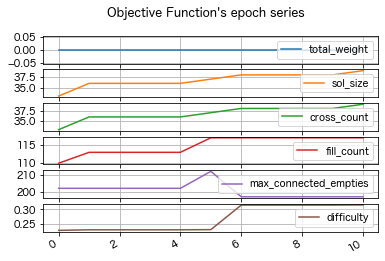

In [12]:
puzzle.show_log()

### パズルの保存
生成されたパズル画像を問題と解答に分けて保存しましょう。  
`Puzzle`クラスには画像を保存するための`save_problem_image`メソッドと`save_answer_image`メソッドが用意されています。  
また， 完成したパズル情報をjson形式で出力するための`export_json`メソッドも用意されています。

In [14]:
oname = f"{dic.name}_w{width}_h{height}_r{seed}.png"
puzzle.save_problem_image(f"fig/problem_{oname}")
print(f"Save as 'fig/problem_{oname}'")

puzzle.save_answer_image(f"fig/answer_{oname}")
print(f"Save as 'fig/problem_{oname}'")

puzzle.export_json(f"json/{oname[:-4]}.json")
print(f"Save as 'json/{oname[:-4]}.json'")

Save as 'fig/problem_pokemon_w15_h15_r1.png'
Save as 'fig/problem_pokemon_w15_h15_r1.png'
Save as 'json/pokemon_w15_h15_r1.json'
